## Processing of cell aggregates

Based on this method http://jck.bio/so-you-want-to-segment-a-cell/

- Processing edges first and fill holes
- Seems to be working efficiently
- No erosion needed

JD

# imports

In [2]:
import numpy as np
import skimage.io as skio
import matplotlib.pyplot as plt

## functions

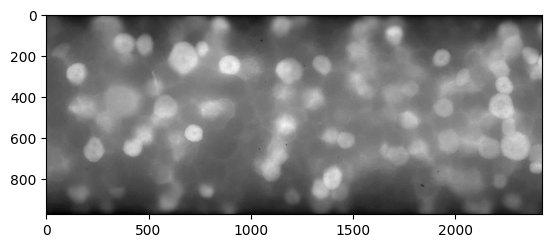

In [99]:
mmPerPixel = 1e-3/0.3135 # 4x long work distance

# Gaussian preprocessing
from skimage.color import rgb2gray
Imorig = skio.imread('sample.png')
Im = rgb2gray(Imorig)

plt.imshow(Im, cmap='gray')
plt.show()

from skimage.filters import gaussian
sigmaGauss = 0.5 # USER DEFINED
I = gaussian(Im, sigmaGauss)

# edge
# from scipy.ndimage.filters import convolve
from scipy.ndimage import convolve
s_x = np.array([[1, 0, -1],
                [2, 0, -2],
                [1, 0, -1]])
s_y = s_x.T # transposes the matrix
res_x = convolve(I, s_x)
res_y = convolve(I, s_y)
G = np.sqrt(res_x**2 + res_y**2)

# Thresholding
from skimage.filters import threshold_otsu
threshold_level = threshold_otsu(G)
bw = G > threshold_level

# Clearing
from skimage.morphology import remove_small_objects, disk
smallSize = 500 # USER DEFINED
bw_cleared = remove_small_objects(bw, smallSize)
# footprint = square(2)
# bw_cleared = erosion(bw_cleared, footprint)

# Closing
from skimage.morphology import binary_closing, binary_dilation, disk
# display(bw_cleared.max())
diskDia = 8 # USER DEFINED
# bw_close = np.invert(binary_closing(bw_cleared, selem=disk(diskDia)))
bw_close = np.invert(binary_closing(bw_cleared, footprint=disk(diskDia)))
# bw_open = binary_opening(bw_cleared, selem=disk(10))

# Labeling
from skimage.measure import label, regionprops_table
bw_label = label(bw_close)

regprops = regionprops_table(bw_label, 
                             properties=['label', 'area'])
regprops['area'] = regprops['area'] * (mmPerPixel**2)
Amin = 1e-4 # mm^2, USER DEFINED
Amax = 1e0  # mm^2, USER DEFINED
for j, j_label in enumerate(regprops['label']):
    if (regprops['area'][j] >= Amin) and (regprops['area'][j] <= Amax):
        bw_label_j = binary_dilation((bw_label == j_label), disk(diskDia)).astype(np.uint8)
        bw_label_j_label = label(bw_label_j)
        
        thisLabel = regionprops_table(bw_label_j_label, properties=['area', 'perimeter', 'orientation', 'centroid', 'minor_axis_length', 'major_axis_length']) # the information of each aggregate, location, area, orientation, etc
        # display(thisLabel)


In [ ]:
# Istack = skio.imread('20230217 kinetix hyperbollic/fitc1 1ms fastest001 10sp.tif', plugin='tifffile')

# data_0 = processEdgeFill(Istack, cropThres=[375, 470], mmPerPixel=mmPerPixel, diskDia=6, Dmin=0, Dmax=0.3)


Raw Image


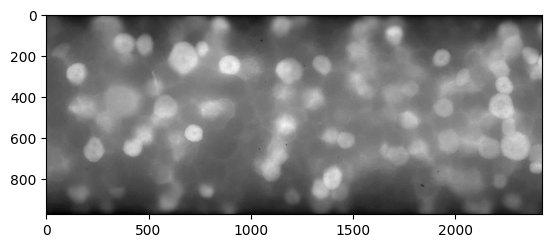

Edge Detection


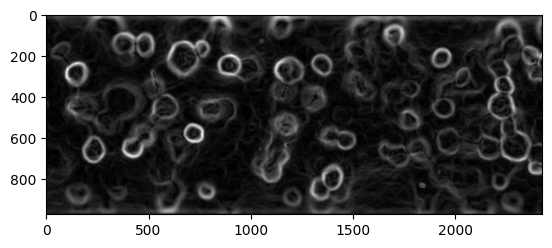

Binarize


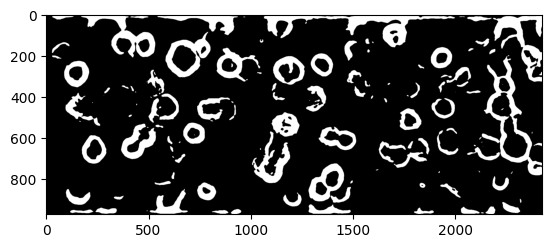

Clear Small Objects


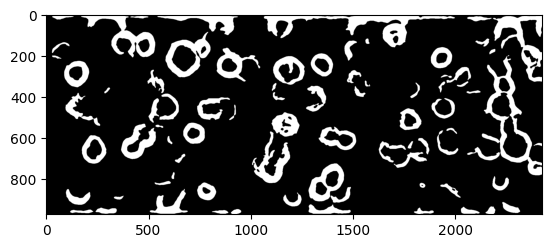

Close outlines


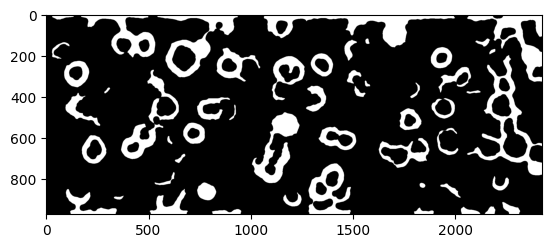

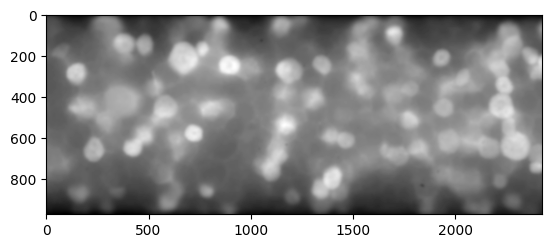

Fill Holes


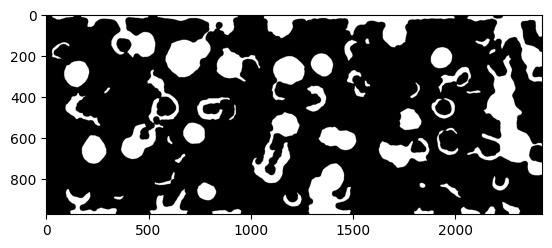

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


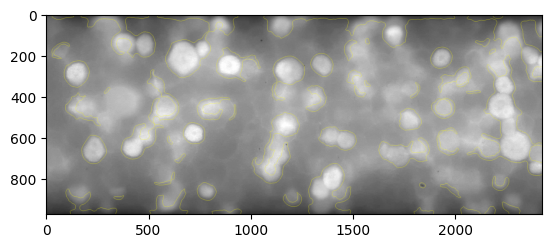

In [158]:
mmPerPixel = 1e-3/0.3135 # 4x long work distance

# Load image and convert to grayscale
from skimage.color import rgb2gray
Imorig = skio.imread('sample.png')
Im = rgb2gray(Imorig)
print("Raw Image")
plt.imshow(Im, cmap='gray')
plt.show()


# Gaussian preprocessing
from skimage.filters import gaussian
sigmaGauss = 5 # USER DEFINED
I = gaussian(Im, sigmaGauss)
# I = Im
# plt.imshow(I, cmap='gray')
# plt.show()


# Edge Detection
from skimage.filters import sobel
G = sobel(I)
print("Edge Detection")
plt.imshow(G, cmap='gray')
plt.show()


# Threshold on edges
from skimage.filters import threshold_otsu
threshold_level = threshold_otsu(G)
# from skimage.filters import threshold_sauvola
# threshold_level = threshold_sauvola(G)
bw = G > threshold_level

print("Binarize")
plt.imshow(bw, cmap='gray')
plt.show()

# Clear any small object noise
from skimage.morphology import remove_small_objects
small_size = 300 # USER DEFINED
bw_cleared = remove_small_objects(bw,300)
print("Clear Small Objects")
plt.imshow(bw_cleared, cmap='gray')
plt.show()


# Close edges of the outlines
from skimage.morphology import binary_closing, binary_opening
disk_rad = 15
bw_close = binary_closing(bw_cleared, footprint=disk(disk_rad))
print("Close outlines")
plt.imshow(bw_close, cmap='gray')
plt.show()


plt.imshow(I, cmap='gray')
plt.show()

# Fill holes
from scipy.ndimage import binary_fill_holes
bw_fill = binary_fill_holes(bw_close)
print("Fill Holes")
plt.imshow(bw_fill, cmap='gray')
plt.show()


# Plot overlay of the binary image
from skimage.segmentation import mark_boundaries
# f = plt.figure()
# plt.imshow(I, cmap='gray', interpolation=None)
# plt.imshow(bw_fill, cmap='gray', alpha=0.1, interpolation=None)
plt.imshow(mark_boundaries(2*Im, bw_fill))
plt.show()

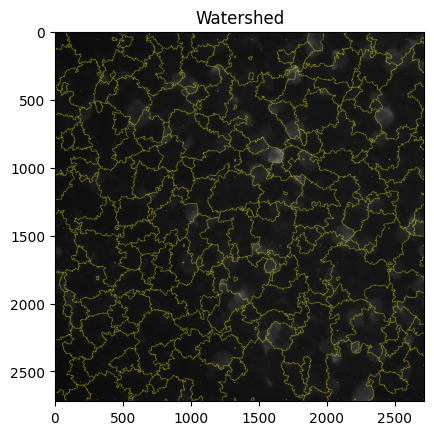

In [138]:
from skimage.util import img_as_float
from skimage.measure import label
from skimage.segmentation import (watershed, mark_boundaries, morphological_geodesic_active_contour, inverse_gaussian_gradient)

# Watershed
a = 2
edges = sobel(a*Im)
im_test1 = watershed(edges, markers=468, compactness=0.000001)
# plt.imshow(im_test1, cmap='gray')
# plt.show()
plt.imshow(mark_boundaries(a*Im, im_test1))
plt.title("Watershed")
plt.show()


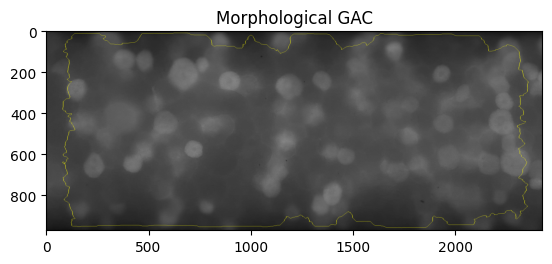

In [89]:
# Morphological Geodesic Active Contour
image = img_as_float(Im)
gradient = inverse_gaussian_gradient(image)
init_ls = np.zeros(image.shape, dtype=np.int8)
init_ls[10:-10, 10:-10] = 1
im_test3 = morphological_geodesic_active_contour(gradient, num_iter=100, init_level_set=init_ls, smoothing=1, balloon=-5, threshold=0.69)
im_test3 = label(im_test3)

plt.imshow(mark_boundaries(Im, im_test3))
plt.title("Morphological GAC")
plt.show()

C:\Users\rcmoo\AppData\Local\Temp\ipykernel_3612\1138468691.py:38: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  contour.collections[0].set_label("Iteration 2")
C:\Users\rcmoo\AppData\Local\Temp\ipykernel_3612\1138468691.py:40: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  contour.collections[0].set_label("Iteration 7")
C:\Users\rcmoo\AppData\Local\Temp\ipykernel_3612\1138468691.py:42: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  contour.collections[0].set_label("Iteration 35")


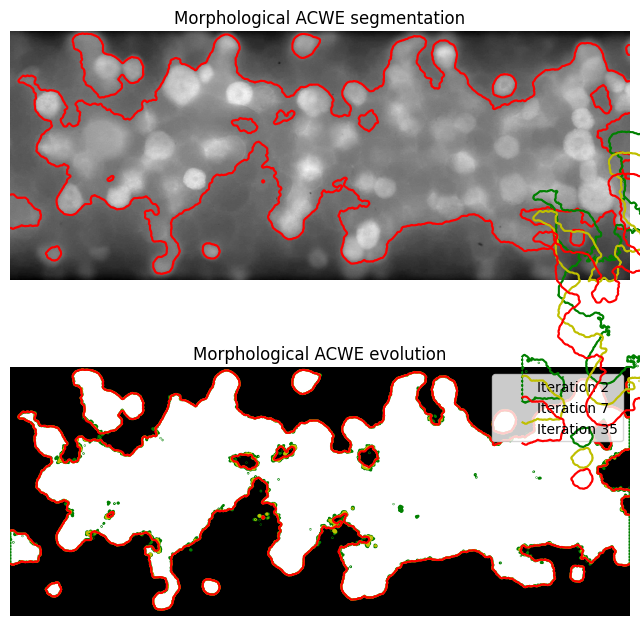

In [90]:
from skimage.segmentation import (morphological_chan_vese,
                                  checkerboard_level_set)


def store_evolution_in(lst):
    """Returns a callback function to store the evolution of the level sets in
    the given list.
    """

    def _store(x):
        lst.append(np.copy(x))

    return _store


# Morphological ACWE
image = img_as_float(Im)

# Initial level set
init_ls = checkerboard_level_set(image.shape, 6)
# List with intermediate results for plotting the evolution
evolution = []
callback = store_evolution_in(evolution)
ls = morphological_chan_vese(image, num_iter=35, init_level_set=init_ls,
                             smoothing=3, iter_callback=callback)

fig, axes = plt.subplots(2, 1, figsize=(8, 8))
ax = axes.flatten()

ax[0].imshow(image, cmap="gray")
ax[0].set_axis_off()
ax[0].contour(ls, [0.5], colors='r')
ax[0].set_title("Morphological ACWE segmentation", fontsize=12)

ax[1].imshow(ls, cmap="gray")
ax[1].set_axis_off()
contour = ax[1].contour(evolution[2], [0.5], colors='g')
contour.collections[0].set_label("Iteration 2")
contour = ax[1].contour(evolution[7], [0.5], colors='y')
contour.collections[0].set_label("Iteration 7")
contour = ax[1].contour(evolution[-1], [0.5], colors='r')
contour.collections[0].set_label("Iteration 35")
ax[1].legend(loc="upper right")
title = "Morphological ACWE evolution"
ax[1].set_title(title, fontsize=12)
plt.show()

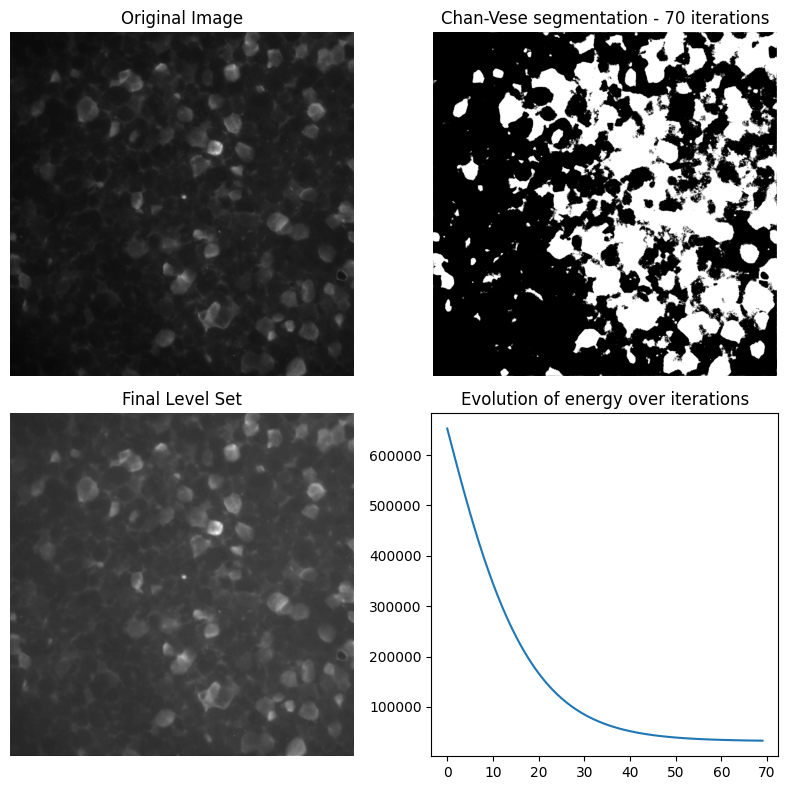

In [139]:
from skimage.segmentation import chan_vese


def store_evolution_in(lst):
    """Returns a callback function to store the evolution of the level sets in
    the given list.
    """

    def _store(x):
        lst.append(np.copy(x))

    return _store


# Chan-Vese
image = img_as_float(Im)

cv = chan_vese(image, mu=0.25, lambda1=1, lambda2=1, tol=1e-4,
               max_num_iter=200, dt=1, init_level_set="checkerboard",
               extended_output=True)

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
ax = axes.flatten()

ax[0].imshow(image, cmap="gray")
ax[0].set_axis_off()
ax[0].set_title("Original Image", fontsize=12)

ax[1].imshow(cv[0], cmap="gray")
ax[1].set_axis_off()
title = f'Chan-Vese segmentation - {len(cv[2])} iterations'
ax[1].set_title(title, fontsize=12)

ax[2].imshow(cv[1], cmap="gray")
ax[2].set_axis_off()
ax[2].set_title("Final Level Set", fontsize=12)

ax[3].plot(cv[2])
ax[3].set_title("Evolution of energy over iterations", fontsize=12)

fig.tight_layout()
plt.show()

0.5363835294117647


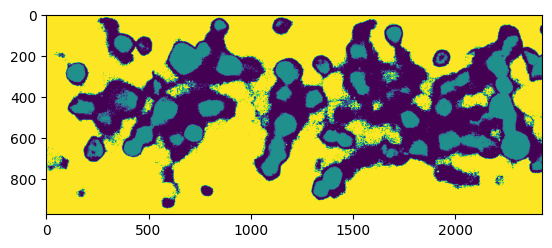

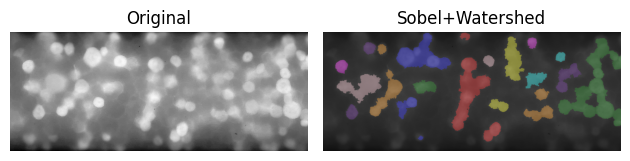

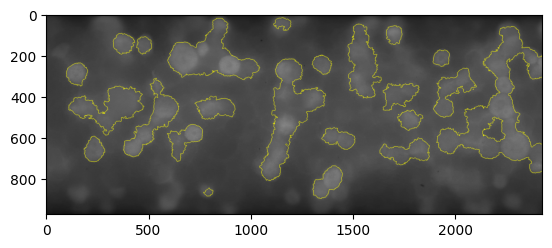

In [133]:
from skimage.measure import label
from skimage.color import label2rgb

edges = sobel(Im)

# markers = np.zeros_like(Im)
markers = np.zeros(Im.shape,dtype=int)
foreground, background = 1, 2
markers[Im < 0.3] = background
markers[Im > 0.37] = foreground

plt.imshow(markers)
plt.show()

ws = watershed(edges,markers)
seg1 = label(ws == foreground)

# plt.imshow(ws)
# plt.show()

# Show the segmentations.
fig, axes = plt.subplots(
    nrows=1,
    ncols=2,
    # figsize=(9, 5),
    sharex=True,
    sharey=True,
)

axes[0].imshow(Im, cmap="Greys_r")
axes[0].set_title("Original")

color1 = label2rgb(seg1, image=Im, bg_label=0)
axes[1].imshow(color1)
axes[1].set_title("Sobel+Watershed")

for a in axes:
    a.axis("off")
fig.tight_layout()
plt.show()

plt.imshow(mark_boundaries(Im, ws))
plt.show()

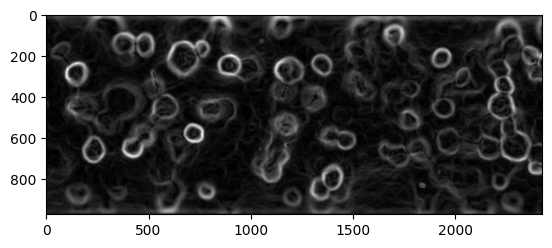

Binarize


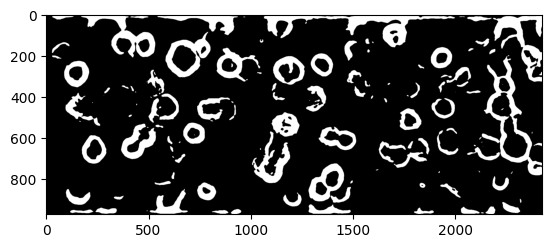

In [194]:
sigmaGauss = 5 # USER DEFINED
I = gaussian(Im, sigmaGauss)
edges = sobel(I)
plt.imshow(edges,cmap='gray')
plt.show()

# Threshold on edges
from skimage.filters import threshold_otsu
threshold_level = threshold_otsu(G)
# from skimage.filters import threshold_sauvola
# threshold_level = threshold_sauvola(G)
bw = edges > threshold_level

print("Binarize")
plt.imshow(bw, cmap='gray')
plt.show()

Work with laplacian


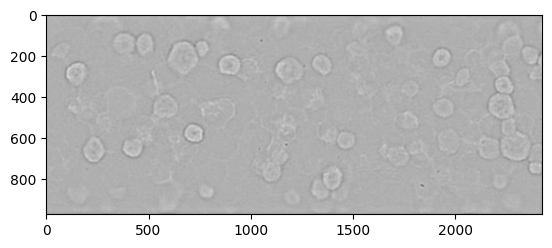

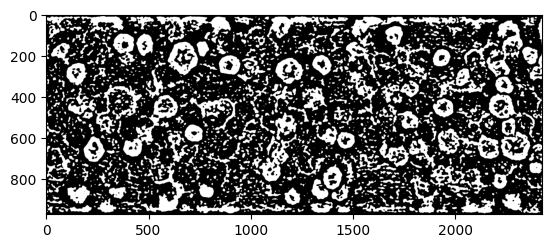

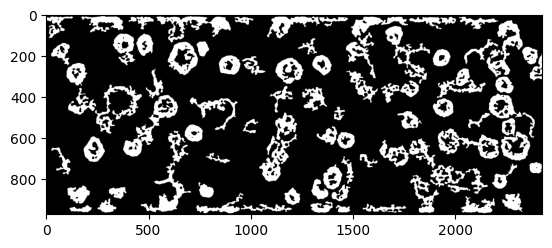

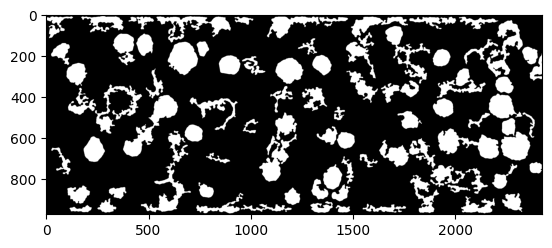

Opening


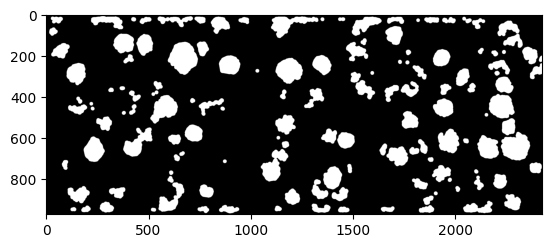

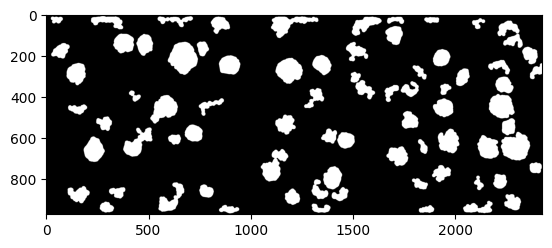

Remove long straggly bits


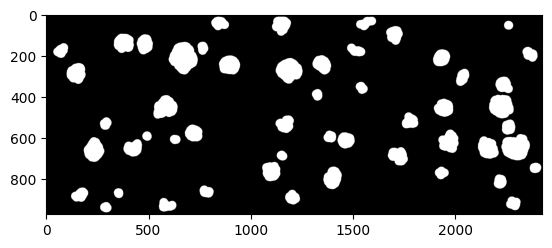

Remove detected areas that are too small


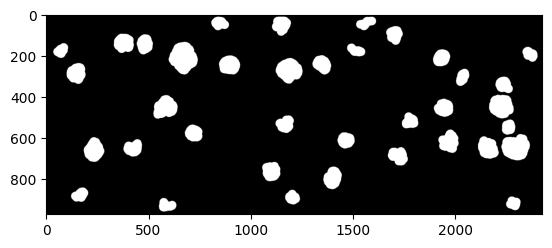

Label regions


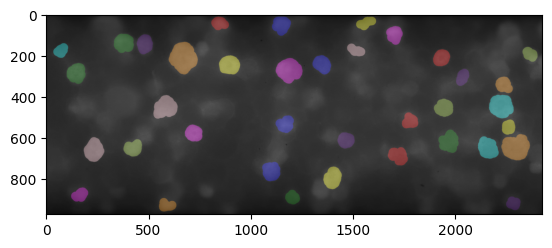

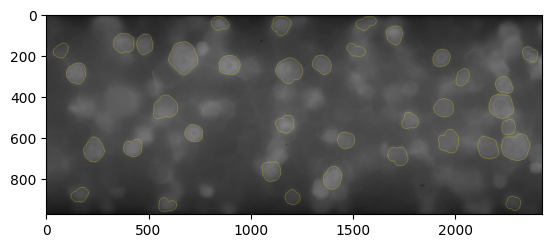

In [219]:
print("Work with laplacian")
from skimage.filters import laplace
lap = laplace(I)
lap = lap / np.max(lap)
plt.imshow(lap, cmap='gray')
plt.show()

threshold = threshold_otsu(lap)
bw = lap > threshold
plt.imshow(bw, cmap='gray')
plt.show()

bw_cleared = remove_small_objects(bw,min_size=1600)
plt.imshow(bw_cleared, cmap='gray')
plt.show()

bw_filled = binary_fill_holes(bw_cleared)
plt.imshow(bw_filled, cmap='gray')
plt.show()

print("Opening")
open_rad = 9
bw_opened = binary_opening(bw_filled, footprint=disk(open_rad))
plt.imshow(bw_opened, cmap='gray')
plt.show()

bw_cleared2 = remove_small_objects(bw_opened, min_size=1500)
plt.imshow(bw_cleared2, cmap='gray')
plt.show()

# # Try to remove thin objcets: erode, remove small objects, and then dilate
# from skimage.morphology import (binary_erosion, binary_dilation)


print('Remove long straggly bits')
open_rad = 21
bw_opened2 = binary_opening(bw_cleared2, footprint=disk(open_rad))
plt.imshow(bw_opened2, cmap='gray')
plt.show()

print('Remove detected areas that are too small')
minArea = 3500
bw_cleared3 = remove_small_objects(bw_opened2, min_size=minArea)
plt.imshow(bw_cleared3, cmap='gray')
plt.show()

print('Label regions')
label_image = label(bw_cleared3)
image_label_overlay = label2rgb(label_image, image=Im, bg_label=0)
plt.imshow(image_label_overlay)
plt.show()

plt.imshow(mark_boundaries(Im, label_image))
plt.show()